In [ ]:
!pip install pytesseract
!apt install tesseract-ocr -y  # For Google Colab or Linux

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Saving sample.jpeg to sample (1).jpeg
✅ 14 emojis detected and classified.
📝 Detected Text (including timestamps if any):
 10:13 Fe)
+92 312 4138669 (You)
< 22 Q Message yourself
6:10PM YW
&
6:10PM YH
Hahaha @ ©@ ©@ @ @ Jha dh ahaalhe
wo 10:13PMWY
10:13PM YZ
Lo)
10:13PM Y
10:13PM WV
©
10:13PM WV
aRNe® 10:13PM WZ
+ O Q


<ipython-input-16-dd90ac56b735>:125: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-dd90ac56b735>:125: UserWarning: Glyph 129326 (\N{FACE WITH OPEN MOUTH VOMITING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-dd90ac56b735>:125: UserWarning: Glyph 129327 (\N{SHOCKED FACE WITH EXPLODING HEAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-dd90ac56b735>:125: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129326 (\N{FACE WITH OPEN MOUTH VOMITING}) missing from font(s) DejaVu Sans.
  fi

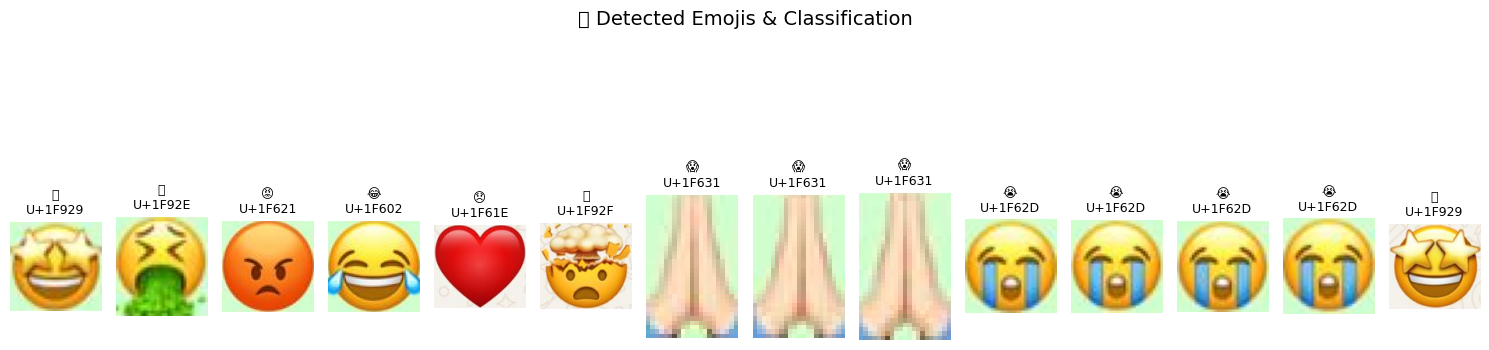

In [ ]:
import cv2, numpy as np, pytesseract
import matplotlib.pyplot as plt
from PIL import Image
import torch, torchvision
import torch.nn as nn
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from google.colab import files  # Only for Google Colab
from functools import reduce  # ✅ Required for mask merging

# Configuration
IMG_SIZE = 64
MODEL_PATH = 'best_model.pth'
DATA_ROOT = '/content/drive/MyDrive/emoji_dataset/train'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Convert palette images with transparency to RGB ---
class ToRGB:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGBA').convert('RGB')
        return img

# Transforms
val_tf = transforms.Compose([
    ToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Load class names
val_ds = ImageFolder(DATA_ROOT, transform=val_tf)
class_names = val_ds.classes
def unicode_label(label): return chr(int(label.replace("U+", ""), 16))

# Load trained model
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, len(class_names))
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()

# --- Emoji detection using HSV + roundness ---
def detect_emojis(image_rgb):
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Multiple color ranges for better detection
    masks = []
    color_ranges = [
        ([15, 80, 80], [45, 255, 255]),     # yellow
        ([0, 30, 60], [20, 255, 255]),      # pale skin tones
        ([160, 100, 50], [180, 255, 255])   # pinkish/red emojis
    ]
    for low, high in color_ranges:
        mask = cv2.inRange(hsv, np.array(low), np.array(high))
        masks.append(mask)

    # Merge masks correctly
    full_mask = reduce(cv2.bitwise_or, masks)
    cleaned = cv2.morphologyEx(full_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=2)

    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        if w < 20 or h < 20 or area < 300:
            continue
        aspect = w / float(h)
        roundness = 4 * np.pi * area / (cv2.arcLength(cnt, True) ** 2 + 1e-5)
        if 0.6 < aspect < 1.4 and roundness > 0.3:
            boxes.append((x, y, x+w, y+h))
    return boxes

# --- Text extraction using Tesseract ---
def extract_text_data(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(gray, config=custom_config)
    return text.strip()

# --- Main classification function ---
def classify_emojis_and_text(image_path):
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    emoji_boxes = detect_emojis(img_rgb)
    text_found = extract_text_data(img_rgb)

    if not emoji_boxes:
        print("❌ No emojis detected.")
    else:
        print(f"✅ {len(emoji_boxes)} emojis detected and classified.")

    if text_found:
        print("📝 Detected Text (including timestamps if any):\n", text_found)
    else:
        print("❌ No text detected.")

    # Draw emoji classification results
    if emoji_boxes:
        plt.figure(figsize=(15, 5))
        for i, (x1, y1, x2, y2) in enumerate(emoji_boxes):
            crop = img_rgb[y1:y2, x1:x2]
            pil_crop = Image.fromarray(crop)
            tensor_img = val_tf(pil_crop).unsqueeze(0).to(device)

            with torch.no_grad():
                flipped = torch.flip(tensor_img, dims=[3])
                logits = model(tensor_img) + model(flipped)
                pred_idx = logits.argmax(1).item()

            pred_unicode = class_names[pred_idx]
            pred_emoji = unicode_label(pred_unicode)

            plt.subplot(1, len(emoji_boxes), i+1)
            plt.imshow(pil_crop)
            plt.title(f"{pred_emoji}\n{pred_unicode}", fontsize=9)
            plt.axis('off')

        plt.suptitle("🔍 Detected Emojis & Classification", fontsize=14)
        plt.tight_layout()
        plt.show()

# --- Upload and classify ---
uploaded = files.upload()
if uploaded:
    image_path = next(iter(uploaded))
    classify_emojis_and_text(image_path)


